In [6]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras import backend as K


In [0]:
from keras.initializers import glorot_uniform
from keras.models import Model


In [0]:
cells=np.load('drive/My Drive/Colab Notebooks/malaria-detector/Cells.npy')
labels=np.load('drive/My Drive/Colab Notebooks/malaria-detector/Labels.npy')

In [0]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]


In [0]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

In [0]:
img_rows=50
img_cols=50
num_classes=2
epochs = 10
batch_size = 120

In [0]:
if K.image_data_format() == 'channels_first':
    train_x = train_x.reshape(train_x.shape[0], 3, img_rows, img_cols)
    test_x = test_x.reshape(test_x.shape[0], 3, img_rows, img_cols)
    eval_x = eval_x.reshape(eval_x.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    train_x = train_x.reshape(train_x.shape[0], img_rows, img_cols, 3)
    eval_x = eval_x.reshape(eval_x.shape[0], img_rows, img_cols, 3)
    test_x = test_x.reshape(test_x.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [16]:
test_y1=test_y
test_y1


array([0, 1, 1, ..., 0, 0, 0])

In [0]:
# convert class vectors to binary class matrices
train_y = keras.utils.to_categorical(train_y, 2)
test_y = keras.utils.to_categorical(test_y, 2)
eval_y = keras.utils.to_categorical(eval_y, 2)

In [18]:
num_classes=len(np.unique(labels))
num_classes


2

In [0]:
#SOURCE:https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X


In [0]:
#source:https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X


In [0]:
def ResNet50(input_shape=(50, 50, 3), classes=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [0]:
model = ResNet50(input_shape = (50, 50, 3), classes = 2)

In [23]:
print(model.summary())

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 56, 56, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 25, 25, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 25, 25, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [46]:
history=model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(eval_x, eval_y))
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 22046 samples, validate on 2756 samples
Epoch 1/10
22046/22046 [==============================] - 34s 2ms/step - loss: 0.0094 - accuracy: 0.9966 - val_loss: 0.3092 - val_accuracy: 0.9546
Epoch 2/10
22046/22046 [==============================] - 34s 2ms/step - loss: 0.0151 - accuracy: 0.9951 - val_loss: 2.5015 - val_accuracy: 0.6001
Epoch 3/10
22046/22046 [==============================] - 33s 2ms/step - loss: 0.0101 - accuracy: 0.9965 - val_loss: 0.3102 - val_accuracy: 0.9441
Epoch 4/10
22046/22046 [==============================] - 34s 2ms/step - loss: 0.0123 - accuracy: 0.9960 - val_loss: 0.2117 - val_accuracy: 0.9579
Epoch 5/10
22046/22046 [==============================] - 34s 2ms/step - loss: 0.0107 - accuracy: 0.9962 - val_loss: 0.7420 - val_accuracy: 0.9028
Epoch 6/10
22046/22046 [==============================] - 34s 2ms/step - loss: 0.0146 - accuracy: 0.9950 - val_loss: 0.7705 - val_accuracy: 0.8110
Epoch 7/10
22046/22046 [==============================] - 34s 2ms/ste

In [47]:
score[1]

0.9535558819770813

In [0]:
def plot_loss_acc_curves(history):
# Loss Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
# Accuracy Curves 
  plt.figure(figsize=[8,6])
  plt.plot(history.history['accuracy'],'r',linewidth=3.0)
  plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

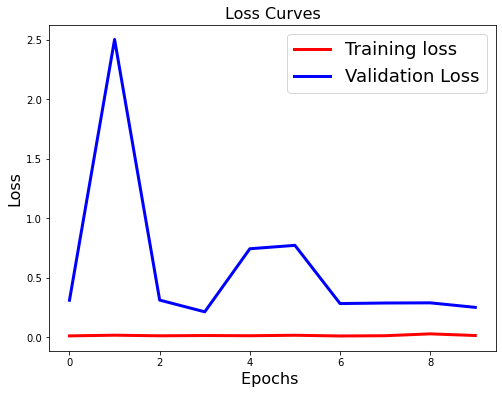

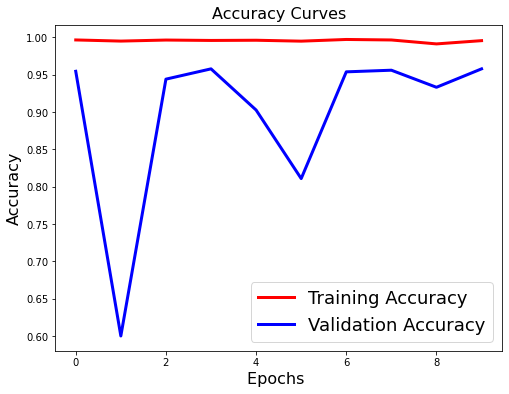

In [49]:
plot_loss_acc_curves(history)

In [0]:
classes=model.predict(test_x,batch_size=128)

In [51]:
classes

array([[9.9988520e-01, 1.1480697e-04],
       [1.5171066e-04, 9.9984825e-01],
       [8.3818000e-33, 1.0000000e+00],
       ...,
       [8.8700974e-01, 1.1299030e-01],
       [9.9985468e-01, 1.4526781e-04],
       [9.9858749e-01, 1.4125480e-03]], dtype=float32)

In [0]:
y_classes = classes.argmax(axis=-1)

In [53]:
y_classes

array([0, 1, 1, ..., 0, 0, 0])

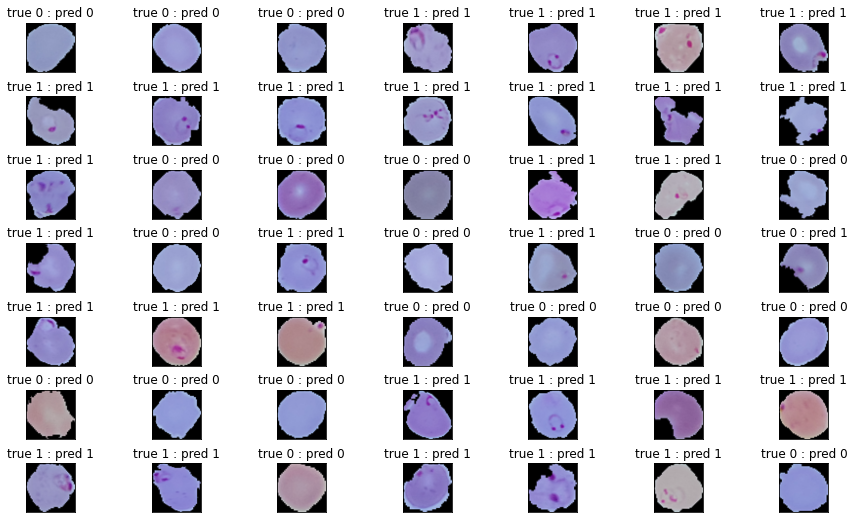

In [54]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , test_x.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(test_x[r[0]])
    plt.title('true {} : pred {}'.format(test_y1[r[0]] , y_classes[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()



In [0]:
model.save("drive/My Drive/Colab Notebooks/malaria-detector/model1.h5")

In [0]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [66]:
#accuracy = accuracy_score(test_y1, y_classes)
#print(accuracy)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_y1, y_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_y1, y_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y1, y_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y1, y_classes)
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(test_y1, y_classes)
print(matrix)

Accuracy: 0.953556
Precision: 0.974721
Recall: 0.933096
F1 score: 0.953455
[[1317   34]
 [  94 1311]]
